In [6]:
!pip install -q transformers datasets librosa

In [7]:
# pip install DATASETS

In [48]:
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import AutoTokenizer, AutoModelForPreTraining
from datasets import load_dataset

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [9]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [10]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "/content/train.csv", "validation": "/content/valid.csv"})
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [11]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'⣷', '⠸', '？', '😆', '⠛', '⡇', '⠻', '청', '⠃', 'К', '😵', ',', '🎖', 'C', 'ß', 'V', '🎏', '🤞', 'p', 'ь', '<', 'T', '병', 'R', 'ɹ', '5', '⡀', '😏', ' ', '🎵', 'f', '💋', '🥀', '😸', '🔪', '加', 'y', 'г', 'Э', '🤷', '💯', 'Ы', '油', '🎉', '💪', '’', '😱', '😹', '🍍', '😾', '🇫', 'u', '➡', 'F', 'O', '玛', 'Г', '什', '🌈', '⣄', 'Х', 'Ш', '(', '⠦', '🚀', 'A', 'о', '😒', '么', '😫', 'ʌ', '⠀', '😋', '🍿', 'D', '👀', '≠', '🤲', '🍁', '你', '在', 'щ', '🎂', '⠊', '👩', 'и', '⠉', '\u200b', '🙂', '#', '👴', '⭐', '⣹', '🤤', '！', 'z', '\\', '⠾', '🖕', '/', '^', 'ф', '⡷', '🌿', '😍', '🏻', 'ə', '🤜', '⠢', '😞', 'ñ', '🤓', '💥', '🅱', 'ē', '😧', '2', '👅', '😛', '😐', 'Т', '⠋', 'j', '♡', '👐', '💃', 'И', '💕', '인', '⠹', 'ч', 'Й', '«', '查', '▫', '⠘', '…', '🚓', 'С', '❄', '清', '🙌', '🙈', '%', 'ɪ', '🚒', '🕺', '♥', 'ё', '😭', '🖤', '😤', '⣠', '⠟', '}', '🐃', '√', '*', 'U', '⠈', '>', 'K', '🇸', 'q', 'g', '👑', '🤗', '❣', '🏿', '⣦', '💨', 'б', '°', '💡', '☹', '😻', '⛏', '🤯', '😮', 'н', '–', 'a', '💭', '💁', 'к', 's', 'r', '🐇', '͡', '⢻', '♫', '👓', '⣘', '🤔', 

#### 📊 Построим гистограммы распределения

In [12]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

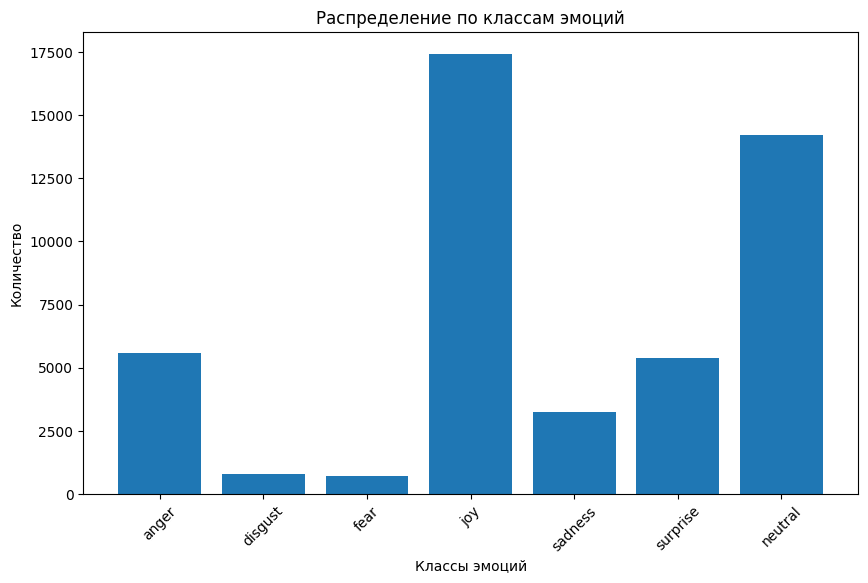

In [13]:
plot_histogram(data["train"])

In [14]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

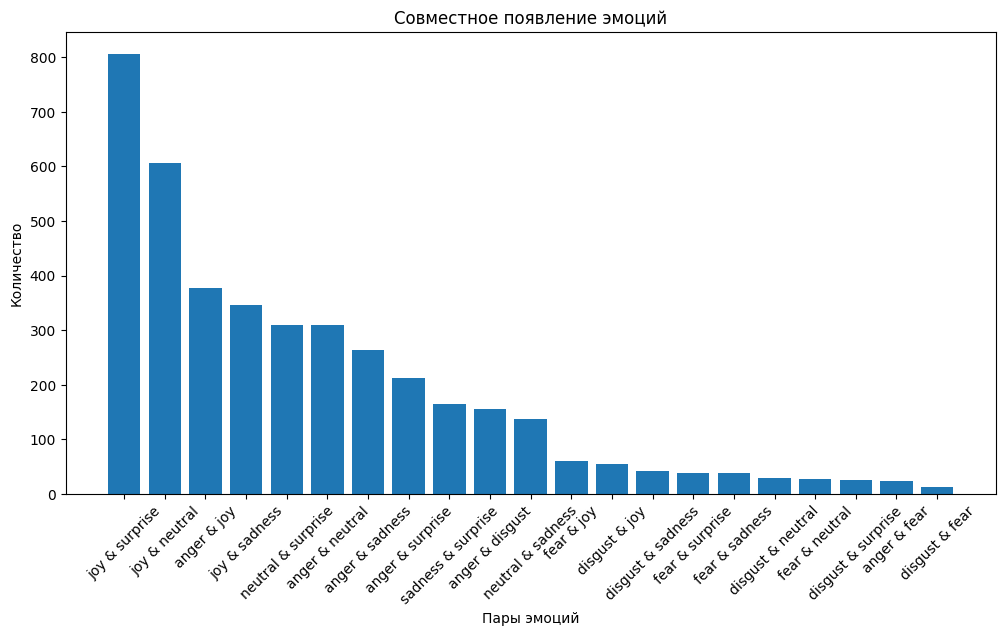

In [15]:
plot_combined_emotions(data["train"])

#### 🧹 Приведем тексты к нижнему регистру и удалим лишние знаки

In [16]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

In [17]:
def cleaner(example):
    example["text"] = example["text"].lower()
    example["text"] = re.sub(r"[^a-zа-я\d]", " ", example["text"])
    example["text"] = re.sub(r"\s+", " ", example["text"])
    example["text"] = example["text"].strip()
    return example

In [18]:
data = data.map(cleaner)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [19]:
# Обработка эмодзи
!pip install emoji
import emoji

def process_emojis(example):
    example["text"] = emoji.demojize(example["text"], delimiters=("", ""))
    return example

data = data.map(process_emojis)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 10.2 MB/s eta 0:00:00


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [20]:
# Обработка ошибок ASR
def process_asr_errors(example):
    asr_error_map = {
        "што": "что",
        "карова": "корова",
        "сечас": "сейчас",
        "патом": "потом",
        "другова": "другого",
        "ебу": "я буду",
        # Расширяем словарь
        "вроде бы": "вроде бы",
        "шя": "сейчас",
        "ыетс": "это",
        "ана": "она",
        "ужеж": "уже",
    }
    for error, correct in asr_error_map.items():
        example["text"] = example["text"].replace(error, correct)
    return example

data = data.map(process_asr_errors)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [21]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

In [22]:
import random
from datasets import concatenate_datasets, DatasetDict

def augment_text(example):
    words = example["text"].split()
    if len(words) > 1:
        random.shuffle(words)  # Перестановка слов
    example["text"] = " ".join(words)
    return example

augmentation_classes = ["disgust", "fear"]
augmented_data = []

# Аугментация данных
for cls in augmentation_classes:
    class_data = data["train"].filter(lambda x: x[cls] == 1)
    augmented_class_data = class_data.map(augment_text)
    augmented_data.append(augmented_class_data)

# Объединяем оригинальные и аугментированные данные
augmented_dataset = concatenate_datasets([data["train"], *augmented_data])

# Обновляем DatasetDict
data = DatasetDict({
    "train": augmented_dataset,
    "validation": data["validation"]
})

# Проверка
print(data["train"][:5])  # Пример первых строк
print(f"Train dataset size: {len(data['train'])}")


Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/726 [00:00<?, ? examples/s]

{'text': ['моя любимая еда это все что мне не приходилось готовить самому', 'теперь если он покончит с собой все будут думать что он смеется трахая людей а не на самом деле мертв', 'какого нахрона бэйлесская изоинция', 'чтобы она почувствовала угрозу', 'грязные южные дрочники'], 'anger': [0, 0, 1, 0, 1], 'disgust': [0, 0, 0, 0, 0], 'fear': [0, 0, 0, 1, 0], 'joy': [0, 0, 0, 0, 0], 'sadness': [0, 0, 0, 0, 0], 'surprise': [0, 0, 0, 0, 0], 'neutral': [1, 1, 0, 0, 0]}
Train dataset size: 44929


In [23]:
print(f"Размер нового train: {len(data['train'])}")

Размер нового train: 44929


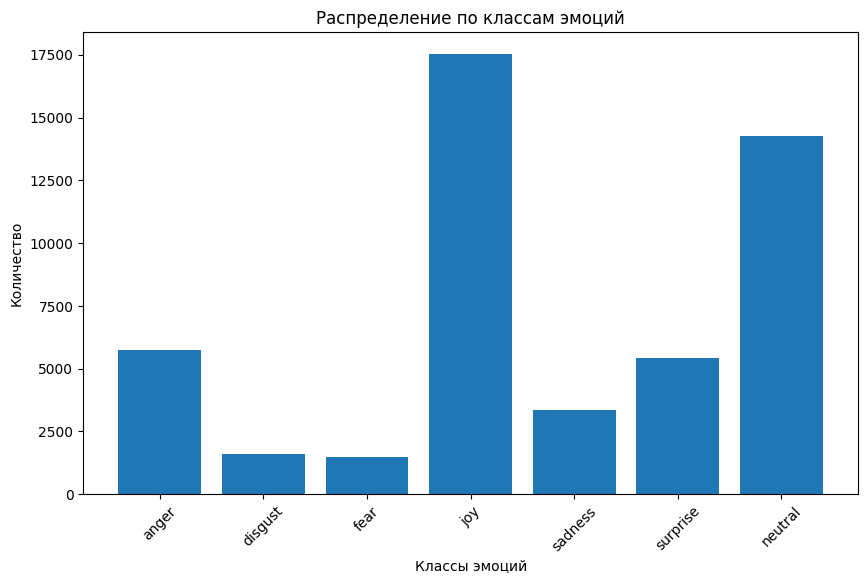

In [24]:
plot_histogram(data["train"])

In [25]:
data["train"][3]

{'text': 'чтобы она почувствовала угрозу',
 'anger': 0,
 'disgust': 0,
 'fear': 1,
 'joy': 0,
 'sadness': 0,
 'surprise': 0,
 'neutral': 0}

In [26]:
for i in range(5):
    print(data["train"][i]["text"])


моя любимая еда это все что мне не приходилось готовить самому
теперь если он покончит с собой все будут думать что он смеется трахая людей а не на самом деле мертв
какого нахрона бэйлесская изоинция
чтобы она почувствовала угрозу
грязные южные дрочники


In [27]:
from datasets import DatasetDict, concatenate_datasets

# Подсчитываем количество примеров в каждом классе
class_distribution = {
    cls: sum(data["train"][cls]) for cls in labels
}
print(f"Class distribution before balancing: {class_distribution}")

# Пример undersampling
balanced_datasets = []
min_count = min(class_distribution.values())
for cls in labels:
    class_samples = data["train"].filter(lambda x: x[cls] == 1)
    balanced_datasets.append(class_samples.shuffle(seed=42).select(range(min_count)))

# Объединяем сбалансированные данные
balanced_train = concatenate_datasets(balanced_datasets)

# Обновляем DatasetDict
data = DatasetDict({
    "train": balanced_train,
    "validation": data["validation"]
})

# Проверка
print(f"Class distribution after balancing: {min_count} samples per class")
print(f"New train dataset size: {len(data['train'])}")


Class distribution before balancing: {'anger': 5758, 'disgust': 1598, 'fear': 1464, 'joy': 17525, 'sadness': 3344, 'surprise': 5431, 'neutral': 14275}


Filter:   0%|          | 0/44929 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44929 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44929 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44929 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44929 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44929 [00:00<?, ? examples/s]

Filter:   0%|          | 0/44929 [00:00<?, ? examples/s]

Class distribution after balancing: 1464 samples per class
New train dataset size: 10248


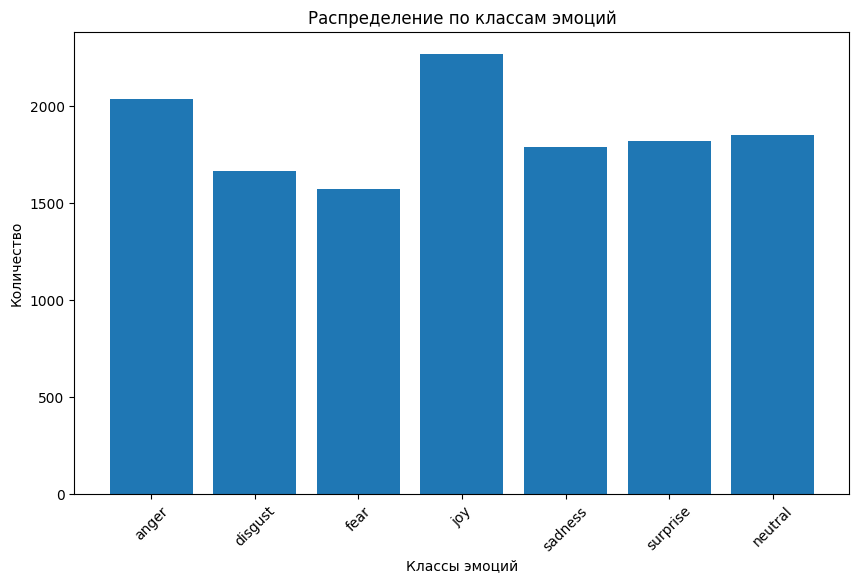

In [28]:
plot_histogram(data["train"])

#### 🏋️ Подготовим модель

In [29]:
# class Model(torch.nn.Module):
#     def __init__(self, pretrained_model, hidden_dim, num_classes):
#         super().__init__()
#         self.bert = AutoModel.from_pretrained(pretrained_model)
#         self.fc = torch.nn.Linear(hidden_dim, num_classes)

#     def forward(self, ids, mask, token_type_ids):
#         _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output = self.fc(features)
#         return output

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Model(pretrained_model="ai-forever/ruBert-base", hidden_dim=768, num_classes=len(labels))
# model = model.to(device)

In [49]:
import torch.nn as nn
from transformers import AutoModel

class Model(nn.Module):
    def __init__(self, pretrained_model, hidden_dim, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        self.dropout = nn.Dropout(p=0.3)  # Dropout для регуляризации
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, ids, mask):
        features = self.bert(input_ids=ids, attention_mask=mask).last_hidden_state[:, 0, :]
        features = self.dropout(features)
        output = self.fc(features)
        return output

# Указываем правильное значение hidden_dim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(pretrained_model="DeepPavlov/distilrubert-tiny-cased-conversational", hidden_dim=768, num_classes=len(labels))
model = model.to(device)


#### 📒 Подготовим данные для обучения

In [50]:
tokenizer = DistilBertTokenizer.from_pretrained("DeepPavlov/distilrubert-tiny-cased-conversational")
max_len = 64

data = data.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length",
                                           return_tensors="pt"), batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

In [51]:
def one_hot_to_list(example):
    emotions = []
    for emotion in labels:
        emotions.append(example[emotion])
    example["one_hot_labels"] = emotions

    return example

data = data.map(one_hot_to_list)
data["train"][9]["one_hot_labels"]

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

[1, 0, 0, 0, 0, 0, 0]

#### 🔗 Dataset & DataLoader

In [52]:
class EmotionDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return {
            'input_ids': torch.tensor(self.dataset[index]["input_ids"], dtype=torch.long),
            'attention_mask': torch.tensor(self.dataset[index]["attention_mask"], dtype=torch.long),
            'labels': torch.tensor(self.dataset[index]["one_hot_labels"], dtype=torch.float)
        }

In [53]:
train_dataset = EmotionDataset(data["train"])
valid_dataset = EmotionDataset(data["validation"])

In [54]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

#### 🚀 Инициализируем функцию ошибки и оптимизатор

In [55]:
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00001, weight_decay=0.)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5, weight_decay=1e-5)

#### 🥷 Код для обучения и валидации

In [59]:
def train(model, criterion, optimizer, dataloader):
    train_loss = 0.0
    model.train()
    for idx, data in enumerate(dataloader):
        ids = data["input_ids"].to(device, dtype=torch.long)
        mask = data["attention_mask"].to(device, dtype=torch.long)
        labels = data["labels"].to(device, dtype=torch.float)

        # Прямой проход
        outputs = model(ids, mask)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Обратный проход
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Train loss: {train_loss / len(dataloader)}')
    return model

In [60]:
def validation(model, criterion, dataloader):
    val_loss = 0.0
    model.eval()
    val_targets, val_outputs = [], []
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            ids = data["input_ids"].to(device, dtype=torch.long)
            mask = data["attention_mask"].to(device, dtype=torch.long)
            labels = data["labels"].to(device, dtype=torch.float)

            # Прямой проход
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Сохранение результатов
            val_targets.extend(labels.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    print(f'Valid loss: {val_loss / len(dataloader)}')
    return val_outputs, val_targets

#### 🏃‍♂️‍➡️ Запускаем обучение

In [61]:
epochs = 5

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    model = train(model, criterion, optimizer, train_dataloader)
    val_outputs, val_targets = validation(model, criterion, valid_dataloader)


Epoch: 0
Train loss: 0.4041880891189812
Valid loss: 0.32425788360483504
Epoch: 1
Train loss: 0.3460603930194926
Valid loss: 0.30157245432629304
Epoch: 2
Train loss: 0.3155042312530257
Valid loss: 0.29335578767692344
Epoch: 3
Train loss: 0.29565096317981343
Valid loss: 0.2955417876734453
Epoch: 4
Train loss: 0.27852056587334745
Valid loss: 0.2910067686263253


In [62]:
outputs, targets = validation(model, criterion, valid_dataloader)
outputs = np.array(outputs) >= 0.5
print(metrics.classification_report(targets, outputs, target_names=labels))

Valid loss: 0.2910067686263253
              precision    recall  f1-score   support

       anger       0.49      0.42      0.45       717
     disgust       0.25      0.55      0.35        97
        fear       0.52      0.56      0.54       105
         joy       0.85      0.67      0.75      2219
     sadness       0.53      0.50      0.52       390
    surprise       0.46      0.42      0.44       624
     neutral       0.72      0.33      0.46      1766

   micro avg       0.66      0.50      0.57      5918
   macro avg       0.55      0.49      0.50      5918
weighted avg       0.69      0.50      0.57      5918
 samples avg       0.51      0.51      0.51      5918



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
from sklearn.metrics import accuracy_score, f1_score

# Бинаризация предсказаний (порог 0.5)
val_outputs_binary = (np.array(val_outputs) >= 0.5).astype(int)

# Повторный расчет метрик
accuracy = accuracy_score(np.array(val_targets), val_outputs_binary)
print(f"Accuracy: {accuracy:.4f}")

weighted_f1 = f1_score(np.array(val_targets), val_outputs_binary, average='weighted', zero_division=0)
print(f"Weighted Average F1-score: {weighted_f1:.4f}")


Accuracy: 0.4464
Weighted Average F1-score: 0.5677


#### ✏️ Получаем результаты на тесте

In [64]:
test = load_dataset("csv", data_files={"test": "/content/test_without_answers.csv"})

Generating test split: 0 examples [00:00, ? examples/s]

In [65]:
test = test.map(lambda examples: tokenizer(examples["text"],
                                           truncation=True,
                                           add_special_tokens=True,
                                           max_length=max_len,
                                           padding="max_length"), batched=True)

test = test.map(one_hot_to_list)

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

Map:   0%|          | 0/8742 [00:00<?, ? examples/s]

In [66]:
test_dataset = EmotionDataset(test["test"])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [67]:
outputs, _ = validation(model, criterion, test_dataloader)
outputs = np.array(outputs) >= 0.5

Valid loss: 0.3099534396747789


#### 🧑‍🍳 Готовим сабмит

In [68]:
import pandas as pd

df = pd.read_csv("/content/test_without_answers.csv")

Изначально все метки классов инициализированы нулями, нужно их заполнить результатами модели.

In [69]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,0,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,0,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,0,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,0


In [70]:
df[labels] = outputs.astype(int)

In [71]:
df.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,надеюсь вы сохранили это письмо,0,0,0,1,0,0,0
1,я зашел в ваш профиль чтобы посмотреть другие ...,0,0,0,1,0,0,0
2,ты реально пустое место,0,0,0,0,0,0,0
3,я не могу сказать счастливый это конец или гру...,0,0,0,0,1,0,0
4,это 8 раундов по разным темам организованных п...,0,0,0,0,0,0,1


In [72]:
df.to_csv("/content/submission.csv", index=False)